# Exploratory analysis on time series data

## Introduction and goals

The purpose of the project is to verify whether timeseries data from the finance domain (such as price of stocks/bonds) can be grouped into meaningful clusters.  
Metadata and details on the timeseries themselves has not been revealed on purpose, for many reasons (including confidentiality).

This notebook contains an initial exploratory analysis of the data, to examine the initial basic details of the series and to determine if there are algorithms or techniques that might be better suited for the cluster analysis.

A second point that was made is about cluster stability: **if clusters do exist, are they stationary over time?**  
This will be investigated deifferently depending on the techniques used to obtain the clusters.

In [1]:
import sys
assert sys.version_info >= (3, 6), "Python 3.6 required for this notebook."

In [2]:
# get latest version of packages
! pip install --upgrade pandas sklearn seaborn jupyterthemes tqdm statsmodels

Requirement already up-to-date: pandas in /Users/pmascolo/anaconda/lib/python3.6/site-packages (0.23.1)
Requirement already up-to-date: sklearn in /Users/pmascolo/anaconda/lib/python3.6/site-packages (0.0)
  Using cached https://files.pythonhosted.org/packages/bc/ee/1921d0f873bd56fca378ad938eaff7cc2ab3e622ed6c035d968924c17677/jupyterthemes-0.19.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/93/24/6ab1df969db228aed36a648a8959d1027099ce45fad67532b9673d533318/tqdm-4.23.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/29/df/1f8233500d8bb90f16fd066560f3805197e568af611ca97eddd5fb81b012/statsmodels-0.9.0-cp36-cp36m-macosx_10_6_intel.macosx_10_9_intel.macosx_10_9_x86_64.macosx_10_10_intel.macosx_10_10_x86_64.whl
Requirement not upgraded as not directly required: numpy>=1.9.0 in /Users/pmascolo/anaconda/lib/python3.6/site-packages (from pandas) (1.14.1)
Requirement not upgraded as not directly required: python-dateutil>=2.5.0 in /Users

In [3]:
import tqdm

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from jupyterthemes import jtplot
from numpy.random import seed
from pandas.plotting import parallel_coordinates

jtplot.style(theme='grade3', ticks=True, grid=False, figsize=(20, 12))

In [4]:
data_file = "../data/time_series_bonds.xlsx"

In [5]:
data = pd.read_excel(data_file, sheet_name="d").set_index("date")
nrows, ncols = data.shape
print(f"Loaded {nrows} rows x {ncols} series")

Loaded 556 rows x 200 series


In [6]:
data.head()

,n1,n4,n5,n6,n7,n10,n11,n12,n13,n14,...,n250,n251,n252,n253,n254,n255,n256,n257,n260,n261
date,,,,,,,,,,,,,,,,,,,,,
d1,120.370,103.701,101.565,100.856,100.326,111.735,101.094,102.522,103.903,105.596,...,102.778,101.933,101.096,101.420,99.892,100.099,102.925,100.122,101.601,103.022
d2,120.210,103.667,101.387,100.652,100.158,111.685,101.091,102.504,103.854,105.537,...,102.641,101.841,101.010,101.302,99.881,100.128,102.707,100.137,101.451,102.775
d3,120.240,103.681,101.484,100.751,100.228,111.690,101.105,102.510,103.860,105.550,...,102.688,101.864,101.044,101.339,99.898,100.128,102.828,100.102,101.478,102.892
d4,120.070,103.639,101.374,100.641,100.130,111.620,101.113,102.473,103.832,105.517,...,102.615,101.816,100.970,101.283,99.934,100.125,102.710,100.129,101.331,102.783
d5,120.165,103.646,101.465,100.778,100.227,111.640,101.149,102.484,103.862,105.549,...,102.696,101.859,101.010,101.333,99.971,100.153,102.853,100.235,101.502,102.908


## Initial observations
The dataset contains 556 rows and 200 time series. The index is the date field, which contains a hash of a date (e.g. 'day1', 'day2', ...).  
We are going to operate under the assumption that each date hash is the same for every series, i.e. 'd5' is the same date for all series.  

The first step is a quick visual analysis of the trend of the series:

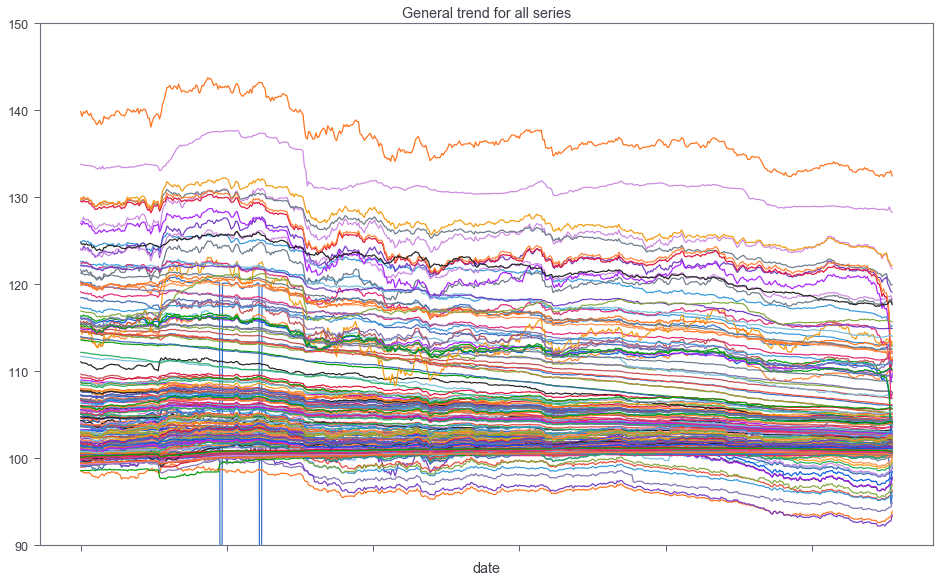

In [7]:
data.plot(legend=False)
plt.ylim(90, 150)
plt.title("General trend for all series")
plt.show()

The graph illustrates some different behaviours in trend. There is at least one series that has dips that go well below the average trend. It is likely that these represent missing data rather than an actual change in behaviour: real systems tend not to have such sharp changes. This will be further investigated in the following sections.  

The general summary statistics for each time series would be the next logical step to verify, before moving to a more in-depth analysis.

In [8]:
statistics = data.describe()

In [9]:
statistics.T

,count,mean,std,min,25%,50%,75%,max
n1,556.0,116.371647,7.421174,0.000,115.26050,116.7945,119.20250,120.845
n4,556.0,102.581772,0.808814,101.025,101.96150,102.6505,103.38250,103.788
n5,556.0,102.033696,0.640860,100.983,101.59075,101.8700,102.19225,103.767
n6,556.0,101.484504,0.717100,100.202,101.00525,101.3035,101.68575,103.433
n7,556.0,100.913275,0.606776,99.752,100.51100,100.7445,101.13525,102.571
n10,556.0,107.451424,2.706196,102.643,105.20675,107.5560,109.82825,111.735
n11,556.0,101.475577,0.300461,100.268,101.40225,101.5720,101.63825,101.797
n12,556.0,101.441919,0.710646,100.096,100.85825,101.5340,102.08900,102.522
n13,556.0,103.144860,0.585048,102.033,102.76625,103.1140,103.68000,104.177
n14,556.0,104.458621,0.827905,102.980,103.90475,104.3930,105.31625,105.865


The series presenting the dips can be identified by setting a threshold on the minimum value:

In [10]:
print("Series with sharp dips:")
dips = statistics.T[statistics.T['min'] < 50]
dips

Series with sharp dips:


,count,mean,std,min,25%,50%,75%,max
n1,556.0,116.371647,7.421174,0.0,115.2605,116.7945,119.2025,120.845


Apparently only one series in the dataset presets a sharp dip, we can verify how many points are represented by zeros (which a likely identifier of missing data).


In [11]:
print("Number of likely anomalous values in series:")
(data[dips.index] < 10).sum()

Number of likely anomalous values in series:


n1    2
dtype: int64

There is a very high chance that the two occurrences of very low values are due to missing or invalid data. It is probably safe to assume that they can be replaced using a simple linear interpolation.

In [12]:
holed_series = np.array([i if i != 0.0 else np.nan for i in data['n1']])
interpolated = pd.Series(holed_series).interpolate()
interpolated.index = data.index
data['n1'] = interpolated

In [13]:
statistics = data.describe()
statistics.T

,count,mean,std,min,25%,50%,75%,max
n1,556.0,116.803686,2.477059,112.445,115.26325,116.8030,119.23975,120.845
n4,556.0,102.581772,0.808814,101.025,101.96150,102.6505,103.38250,103.788
n5,556.0,102.033696,0.640860,100.983,101.59075,101.8700,102.19225,103.767
n6,556.0,101.484504,0.717100,100.202,101.00525,101.3035,101.68575,103.433
n7,556.0,100.913275,0.606776,99.752,100.51100,100.7445,101.13525,102.571
n10,556.0,107.451424,2.706196,102.643,105.20675,107.5560,109.82825,111.735
n11,556.0,101.475577,0.300461,100.268,101.40225,101.5720,101.63825,101.797
n12,556.0,101.441919,0.710646,100.096,100.85825,101.5340,102.08900,102.522
n13,556.0,103.144860,0.585048,102.033,102.76625,103.1140,103.68000,104.177
n14,556.0,104.458621,0.827905,102.980,103.90475,104.3930,105.31625,105.865


### General distributions per of summary statistics 

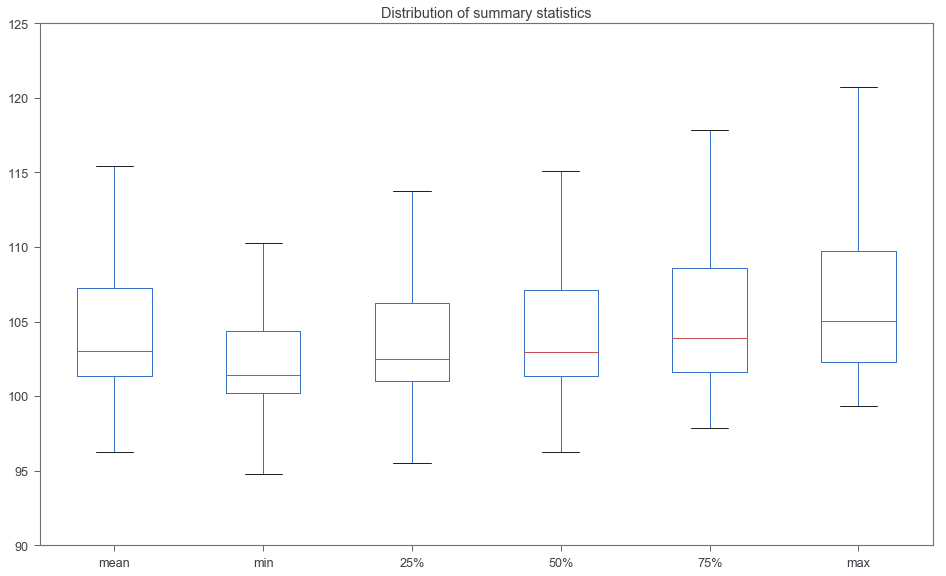

In [14]:
statistics.T.drop(['count', 'std'], axis=1).plot(kind='box')
plt.title("Distribution of summary statistics")
plt.ylim(90, 125)
plt.show()

The distribution of summary statistics show some relatively well behaved distributions. There is not a lot of difference between different quartiles, which suggests absence of strong outliers (which was also shows in the initial graph on trends).

### Initial attempts at veryfying presence of groups
The first technique used to determine presence of strong groups is a parallel coordinate plot on summary statistics. This technique can help to visually verify the presence of sub-communities. `counts` and `std` are not included in the initial graph due to invariance or different scale.

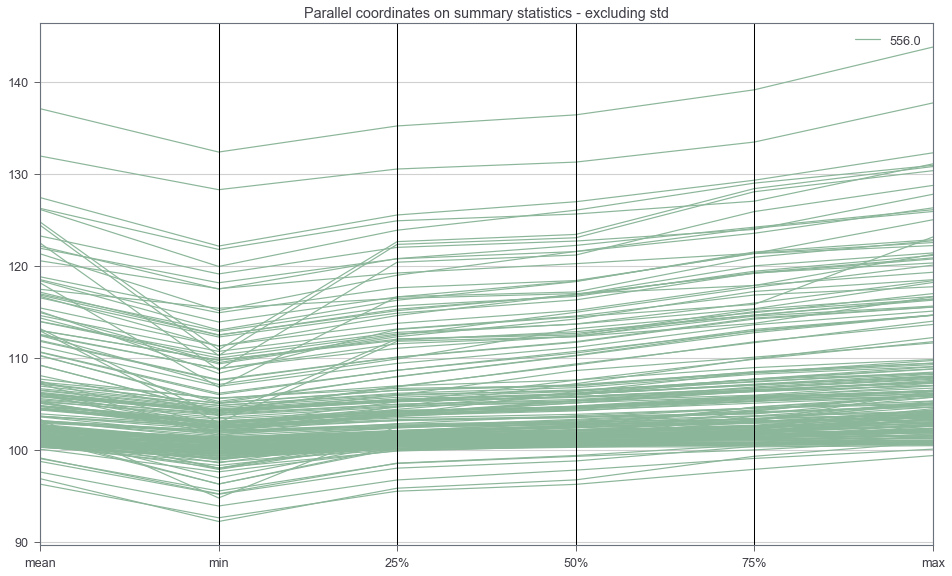

In [15]:
parallel_coordinates(statistics.T.drop(['std'], axis=1), 'count')
plt.title("Parallel coordinates on summary statistics - excluding std")
plt.show()

Groups are hard to identify in the plot, we can add the standard deviation and rescale to see if that improves the situation.

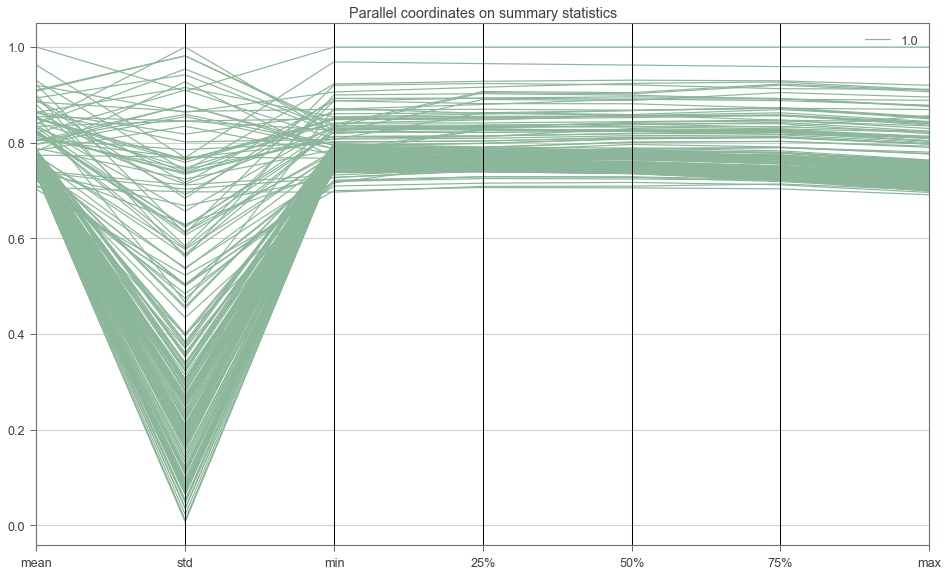

In [16]:
parallel_coordinates(statistics.T / statistics.T.max(), 'count')
plt.title("Parallel coordinates on summary statistics")
plt.show()

Standard deviation seems to add a high degree of variability to the dataset. It is probably not going to add a lot of information, but it's a clear indicator that most of the difference in the timeseries is probably contained in their time evolution rather than in static summary statistics.  
Part of the time evolution can be reperesented by proxy and used to come up with representative embeddings that can separate different groups of items.

# A quick decomposition analysis
Decomposition and feature reduction techniques can be attempted in order to verify the presence of linearly separable groups (PCA) or non-linearly separable groups (T-SNE).

## Linear representation - PCA

In [17]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(statistics.T)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [18]:
pca.explained_variance_ratio_

array([0.98417685, 0.01339636])

As visible in the cell above, the first component alone is able to explain $98\%$ of the dataset variability. The features that make up that component are easily accessible:

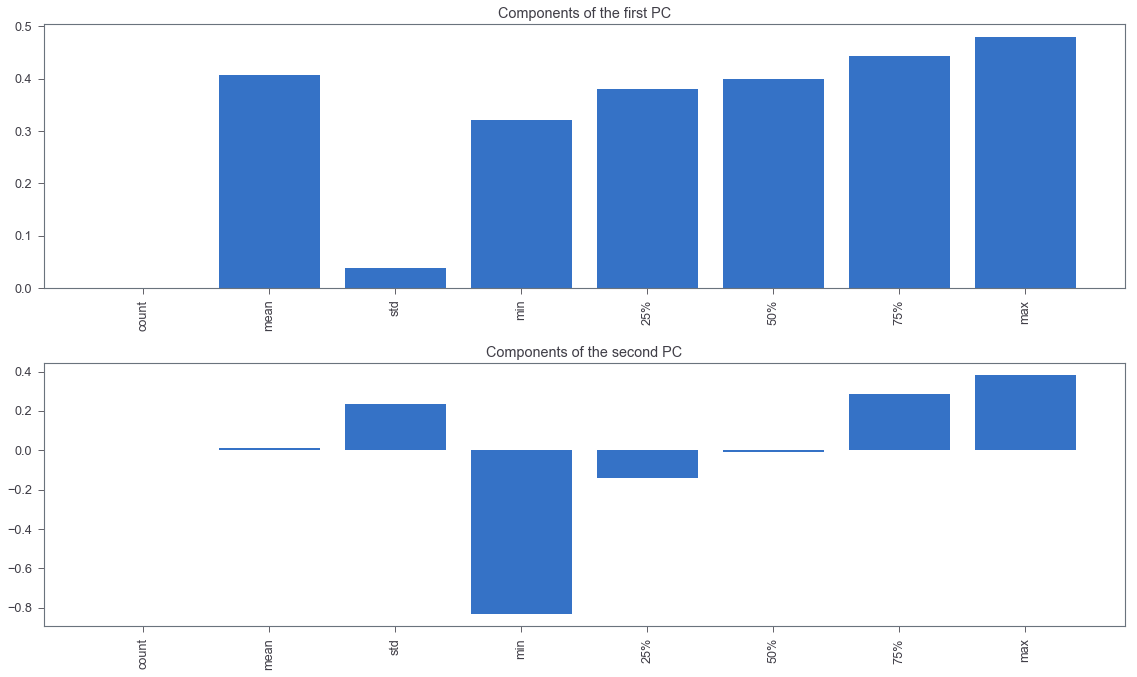

In [19]:
plt.subplot(2, 1, 1)
plt.bar(range(statistics.T.shape[1]), pca.components_[0])
plt.xticks(range(statistics.T.shape[1]), statistics.T.columns, rotation=90)
plt.title("Components of the first PC")

plt.subplot(2, 1, 2)
plt.bar(range(statistics.T.shape[1]), pca.components_[1])
plt.xticks(range(statistics.T.shape[1]), statistics.T.columns, rotation=90)
plt.title("Components of the second PC")

plt.tight_layout()
plt.show()

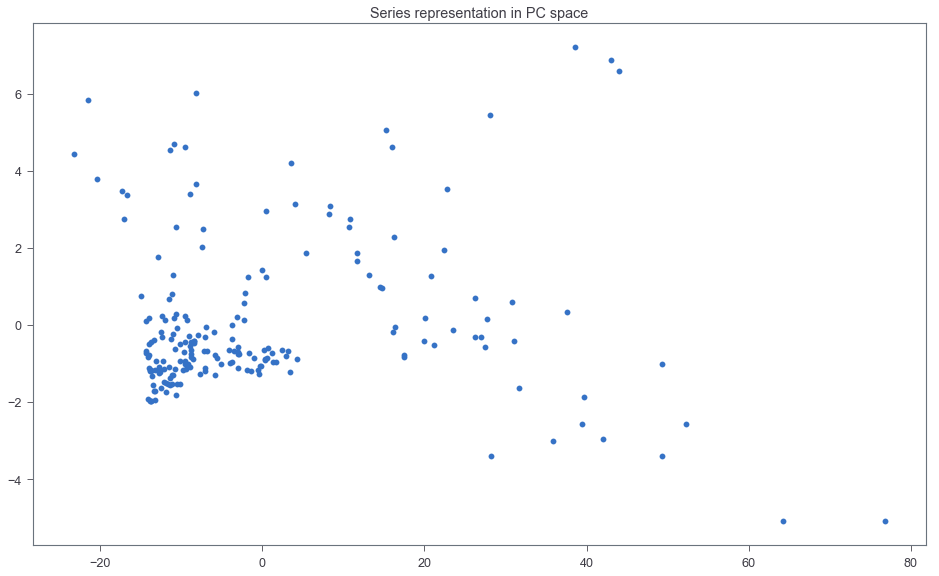

In [20]:
plt.scatter(*list(zip(*pca.transform(statistics.T))))
plt.title("Series representation in PC space")
plt.show()

The graph in PC space shows that there are groups of different behaviours when it comes to global summary statistics. A second pass using PCA should be performed on scaled data as variance is obviously sensitive to scale.  

In [21]:
scaled_stats = statistics.T / statistics.T.max()

pca_scaled = PCA(n_components=2)
pca_scaled.fit(scaled_stats)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [22]:
pca_scaled.explained_variance_ratio_

array([0.9314316 , 0.06748259])

In this case the explaining power of the the two first PC is also very strong ($>99\%$).

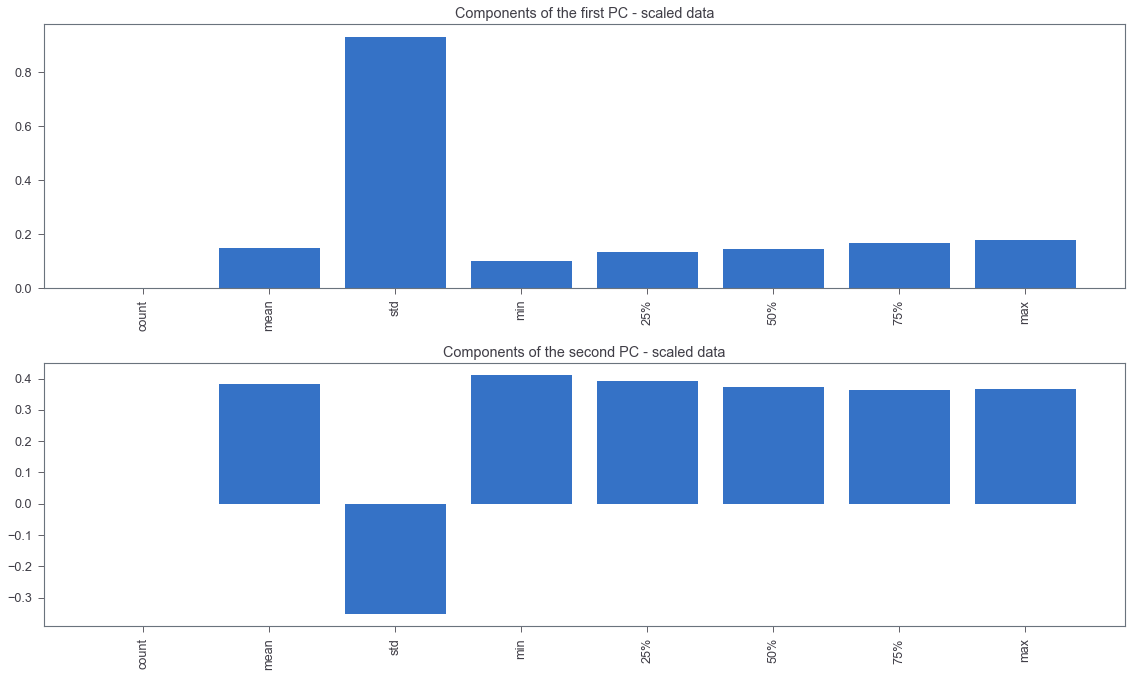

In [23]:
plt.subplot(2, 1, 1)
plt.bar(range(scaled_stats.shape[1]), pca_scaled.components_[0])
plt.xticks(range(scaled_stats.shape[1]), scaled_stats.columns, rotation=90)
plt.title("Components of the first PC - scaled data")

plt.subplot(2, 1, 2)
plt.bar(range(scaled_stats.shape[1]), pca_scaled.components_[1])
plt.xticks(range(scaled_stats.shape[1]), scaled_stats.columns, rotation=90)
plt.title("Components of the second PC - scaled data")
plt.tight_layout()
plt.show()

As expected (see parallel coordinate graphs above), the standard deviation plays a large role in differentiating behaviours (or at least in maximizing variance).

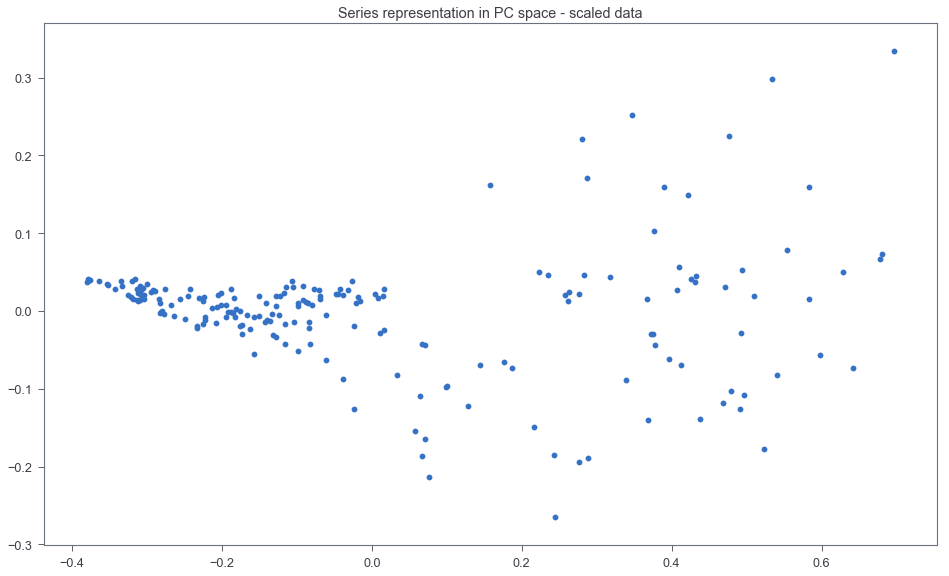

In [24]:
plt.scatter(*list(zip(*pca_scaled.transform(scaled_stats))))
plt.title("Series representation in PC space - scaled data")
plt.show()

## Non-linear representation - TSNE
T-SNE is a stochastic manifold algorithm that represents data over a manifold. It can create representation that can lead to interesting insight on multi-dimensional data. T-SNE will be applied to scaled and non scaled data to verify presence of clusters (default parameters only).

In [25]:
from sklearn.manifold import TSNE

tsne = TSNE()
tsne_scaled = TSNE()

In [26]:
%%time
tsne.fit(statistics.T)
tsne_scaled.fit(scaled_stats)

CPU times: user 4.46 s, sys: 610 ms, total: 5.07 s
Wall time: 5.1 s


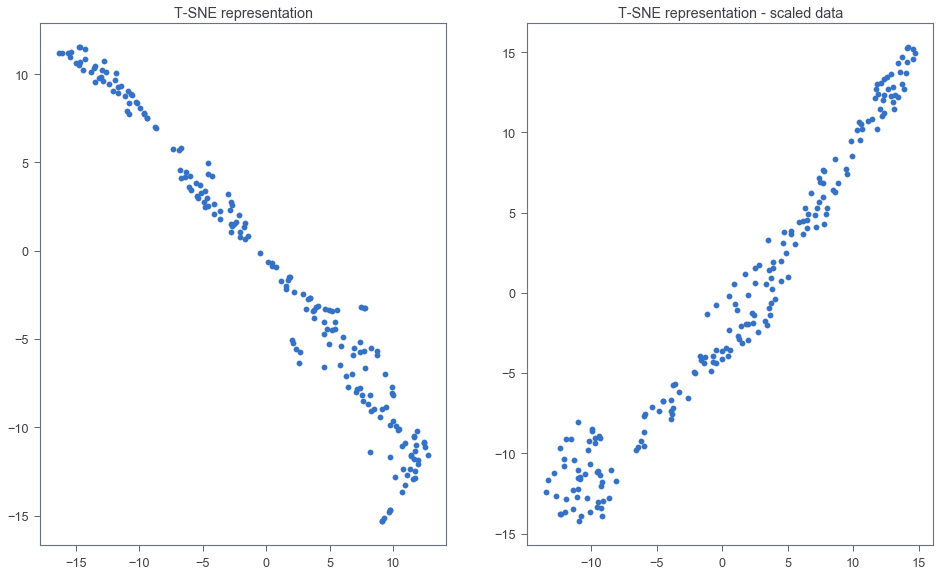

In [27]:
plt.subplot(1, 2, 1)
plt.title("T-SNE representation")
plt.scatter(*list(zip(*tsne.embedding_)))
plt.subplot(1, 2, 2)
plt.title("T-SNE representation - scaled data")
plt.scatter(*list(zip(*tsne_scaled.embedding_)))

plt.show()

As expected, the two representations don't vary much (being stochastic manifold representations). Some conclusions that can be inferred from the graphs:

There aren't clearly separable groups, although some degree of separation exists. Determination of more features or better embedding might be neessary to obtain a clearer separation of clusters.

# Representation of the time evolution in a static embedding
A simple representation of a time series is the decomposition in trend and seasonality. in essence, a series is represented by the sum (or product) of three components depending on teh general trend:

Additive model:
$$Y(t) = T(t) + S(t) + E(r)$$

Multiplicative model:
$$Y(t) = T(t) \times S(t) \times E(r)$$
  
    
where $Y(t)$ represents trend, $S(T)$ seasonality and $E(t)$ is the error or the residuals remaining to get to the original series.

The choice between the two models is dictated by the general trend of the series. In the analysed case, an additive model makes more sense as the scale and trend of the series does not vary considerably.

## An example of seasonality analysis

In [28]:
# seasonality example
from statsmodels.tsa import seasonal
seasonality = seasonal.seasonal_decompose(data['n1'].values, freq=30)  # frequency of decomposition -> 1 month

/Users/pmascolo/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


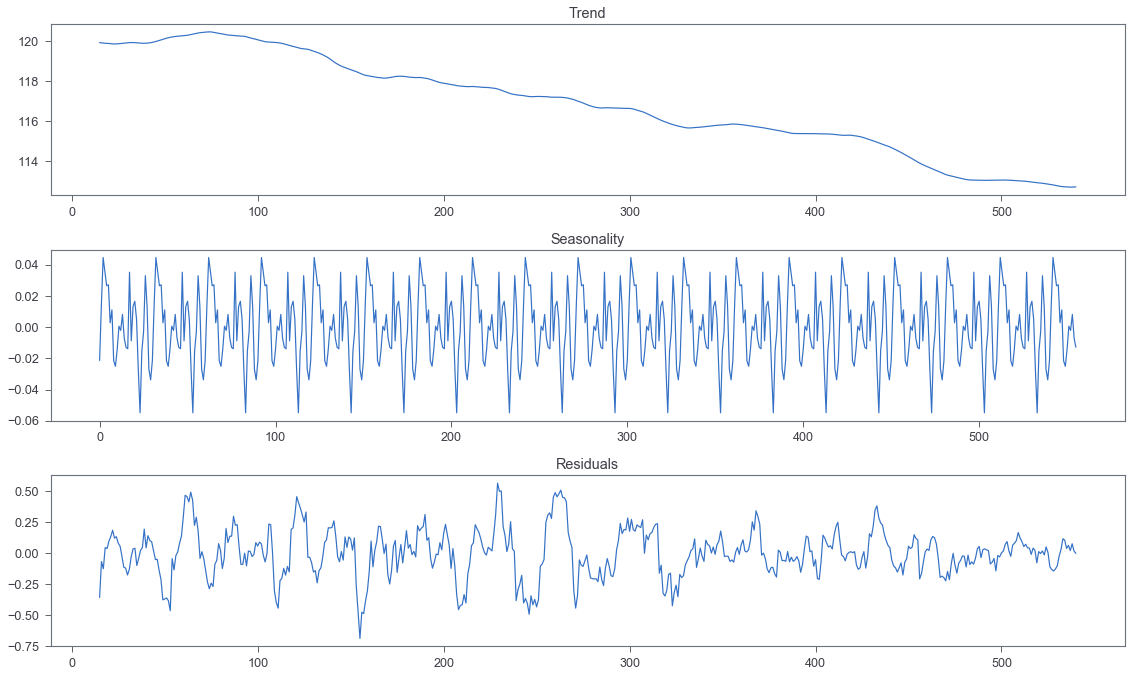

In [29]:
plt.subplot(3, 1, 1)
plt.plot(seasonality.trend)
plt.title("Trend")
plt.subplot(3, 1, 2)
plt.plot(seasonality.seasonal)
plt.title("Seasonality")
plt.subplot(3, 1, 3)
plt.plot(seasonality.resid)
plt.title("Residuals")
plt.tight_layout()
plt.show()

In this case the trend encodes most of the variance of the series. Seasonality's scale is bsaically irrelevant (no real seasonality) as it's less than 10% of the residuals.  

For clustering, the idea is that summary statistics of the decomposition encode more information than just the summary statistics of the original series.

## Seasonality decomposition for all time series

In [30]:
seasons = list()

for column in tqdm.tqdm_notebook(list(data)):
    decomposed = seasonal.seasonal_decompose(data[column].values, freq=90)
    column_dict = {"columns": column}
    for component in ("trend", "seasonal", "resid"):
        component_data = getattr(decomposed, component)
        component_dict = pd.Series(component_data).describe(percentiles=[0.025, 0.25, 0.5, 0.75, 0.9, 0.99]).T.to_dict()
    
        for k, v in component_dict.items():
            if k == 'count':
                continue
            column_dict[f"{component}_{k}"] = v
    seasons.append(column_dict)

df = pd.DataFrame(seasons)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [31]:
df.head()

,columns,resid_2.5%,resid_25%,resid_50%,resid_75%,resid_90%,resid_99%,resid_max,resid_mean,resid_min,...,trend_2.5%,trend_25%,trend_50%,trend_75%,trend_90%,trend_99%,trend_max,trend_mean,trend_min,trend_std
0,n1,-0.508932,-0.186522,0.016006,0.207755,0.384513,0.641571,0.794159,0.013704,-0.862660,...,113.077217,115.456254,116.824983,118.606421,120.070539,120.149504,120.158583,116.876193,112.937550,2.119955
1,n4,-0.080254,-0.015030,0.007621,0.029942,0.057121,0.120518,0.145368,0.007702,-0.105195,...,101.411309,102.065297,102.627917,103.166736,103.642072,103.662033,103.663483,102.611143,101.335761,0.687639
2,n5,-0.445807,-0.150728,0.033745,0.217832,0.309324,0.532589,0.588848,0.022878,-0.629630,...,101.483601,101.770304,101.876986,102.343281,103.055117,103.314189,103.317050,102.100987,101.461789,0.512021
3,n6,-0.556508,-0.178113,0.047619,0.258405,0.370241,0.625078,0.721062,0.026934,-0.734228,...,100.935380,101.189392,101.297786,101.779353,102.596667,102.898901,102.902739,101.563621,100.902094,0.553003
4,n7,-0.483328,-0.154177,0.035701,0.225956,0.313832,0.543239,0.648322,0.022653,-0.677362,...,100.511446,100.638094,100.770111,101.117850,101.833844,102.100241,102.103222,100.972831,100.494139,0.465011


In [32]:
df.shape

(200, 31)

The new dataset consists of 200 records represented by 30 features each. There is no need to add the original series statistics as they can be linearly deduced from the current dataset.

In [33]:
pca_seasons = PCA(n_components=2)

In [34]:
pca_seasons.fit(df.drop('columns', axis=1))

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [35]:
pca_seasons.explained_variance_ratio_

array([0.99052397, 0.00739633])

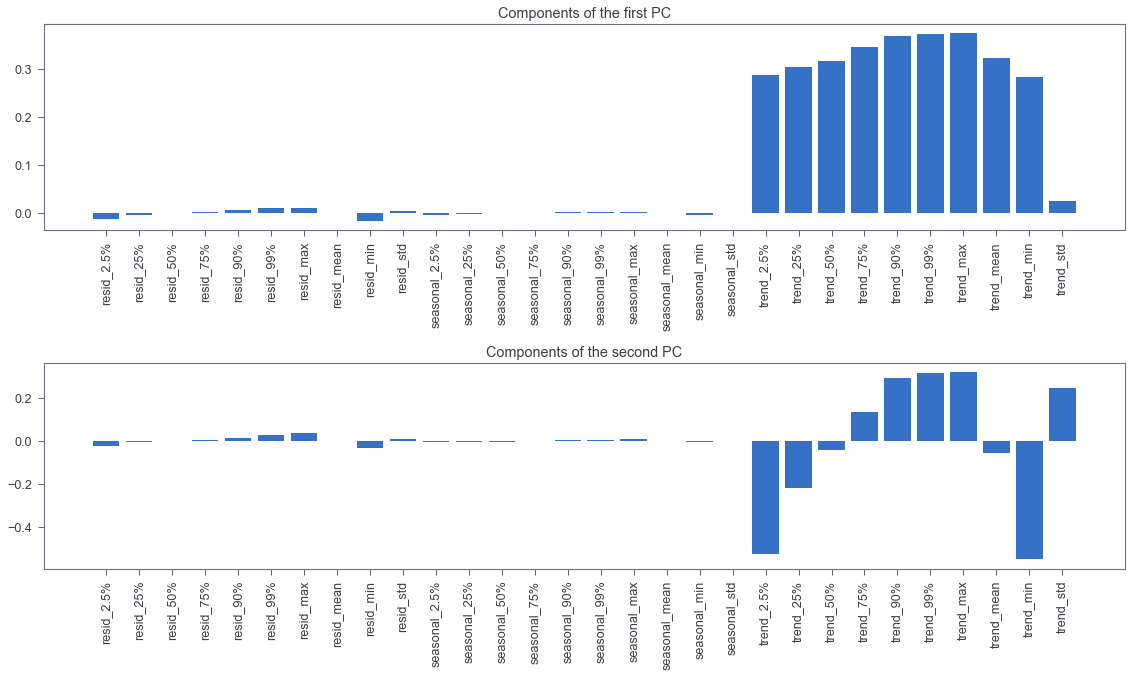

In [36]:
plt.subplot(2, 1, 1)
plt.bar(range(df.shape[1] - 1), pca_seasons.components_[0])
plt.xticks(range(df.shape[1] - 1), df.drop('columns', axis=1).columns, rotation=90)
plt.title("Components of the first PC")

plt.subplot(2, 1, 2)
plt.bar(range(df.shape[1] - 1), pca_seasons.components_[1])
plt.xticks(range(df.shape[1] - 1), df.drop('columns', axis=1).columns, rotation=90)
plt.title("Components of the second PC")
plt.tight_layout()
plt.show()

Not unexpectedly, in this case, trend contains most information regarding the series.

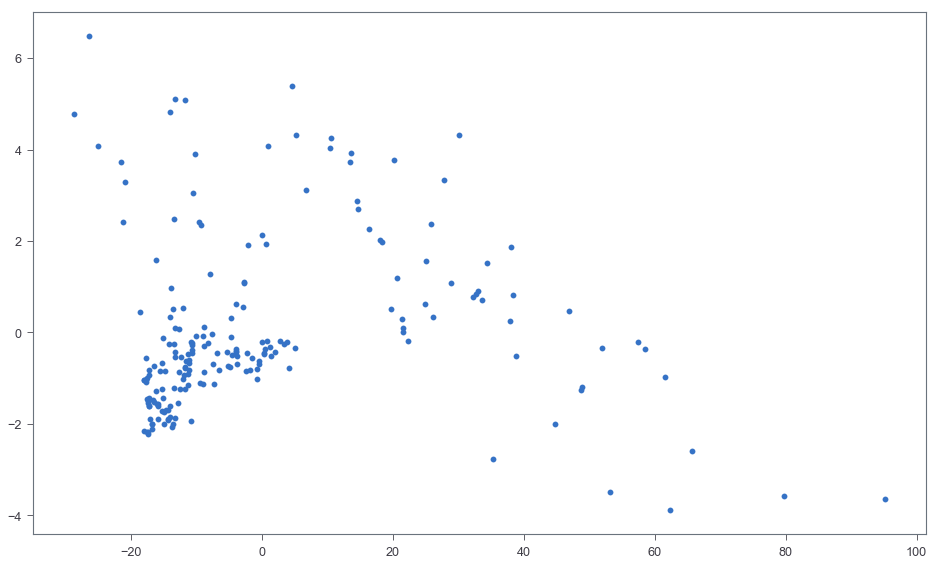

In [37]:
plt.scatter(*list(zip(*pca_seasons.transform(df.drop('columns', axis=1)))))
plt.show()

In [38]:
tsne_seasons = TSNE()

In [39]:
%%time
tsne_seasons.fit(df.drop('columns', axis=1))

CPU times: user 2.07 s, sys: 303 ms, total: 2.37 s
Wall time: 2.37 s


TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=None, verbose=0)

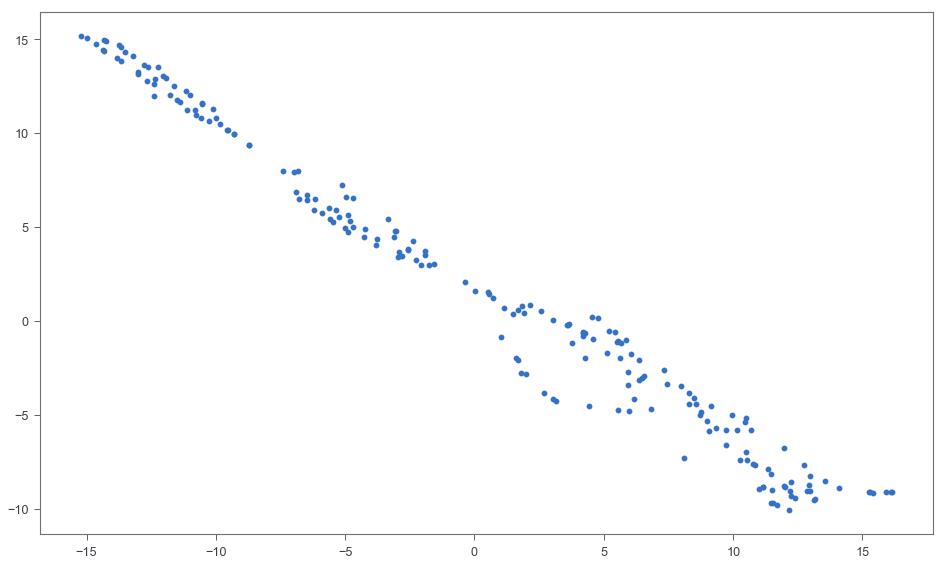

In [40]:
plt.scatter(*list(zip(*tsne_seasons.embedding_)))
plt.show()

The manifold learned by T-SNE is not different in shape from the one determined using global analysis. This confirms the fact that the components determined using seasonal decomposition retain the bulk of the variance in the trend.

Experiments were conducted using weeks, months and trimesters as frequency period for seasonality with no significant variations.

This results suggest that using seasonal decomposition is not adding any

# Verification of the groups identified by PCA

Remembering the structure of the two graphs obtained from PCA (scaled and raw data), a representative embedding can be extracted from those.

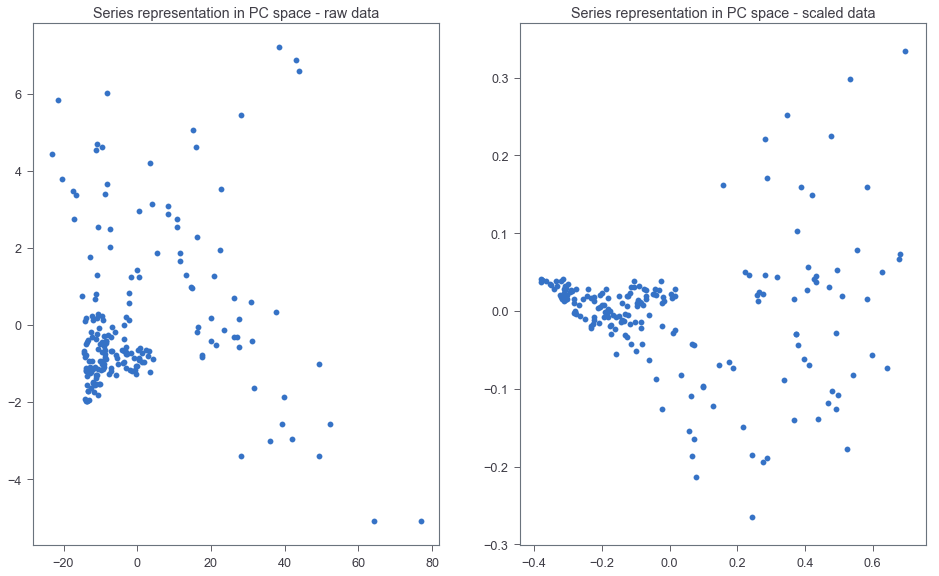

In [41]:
plt.subplot(1, 2, 2)
plt.scatter(*list(zip(*pca_scaled.transform(scaled_stats))))
plt.title("Series representation in PC space - scaled data")

plt.subplot(1, 2, 1)
plt.scatter(*list(zip(*pca.transform(statistics.T))))
plt.title("Series representation in PC space - raw data")
plt.show()

In [42]:
embeddings = pd.DataFrame(
    np.concatenate(
        [pca.transform(statistics.T), pca_scaled.transform(scaled_stats)], 
        axis=1
    ),
    columns="PC1 PC2 PC1_scaled PC2_scaled".split()
)
embeddings.shape

(200, 4)

In [43]:
embeddings.describe().T

,count,mean,std,min,25%,50%,75%,max
PC1,200.0,-6.234124e-14,17.425480,-23.223827,-11.422989,-7.231787,3.495622,76.852278
PC2,200.0,-8.500978e-15,2.033019,-5.089062,-1.139205,-0.653182,0.387105,7.201990
PC1_scaled,200.0,-7.494005e-17,0.288529,-0.380129,-0.224166,-0.091943,0.243572,0.696058
PC2_scaled,200.0,-1.296619e-16,0.077662,-0.265137,-0.021516,0.012760,0.027892,0.333806


Given the scales, it is expected that PC1 and PC2 will control most of the explaining power of the series.  
Additional information might be included inthe derivative of the series.

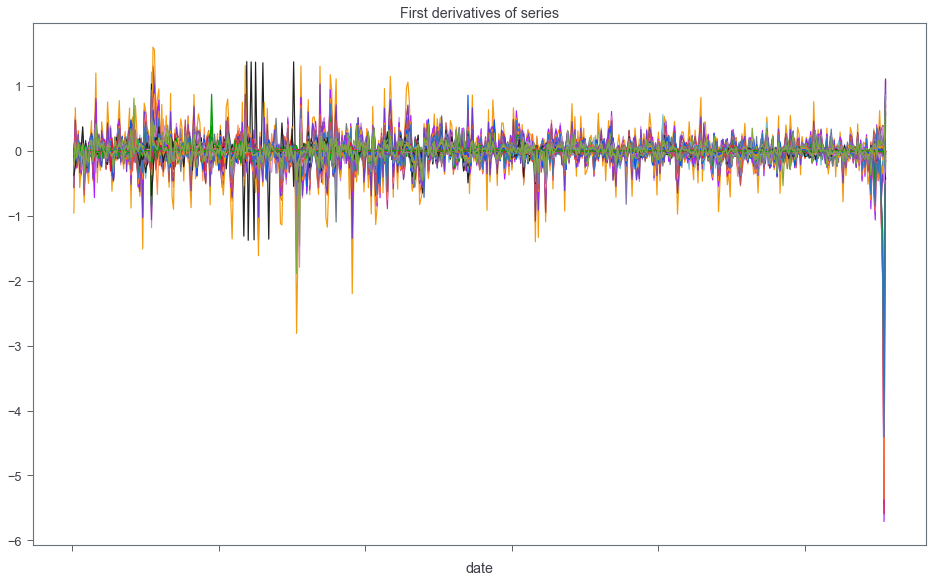

In [44]:
data.diff().plot(legend=False)
plt.title("First derivatives of series")
plt.show()

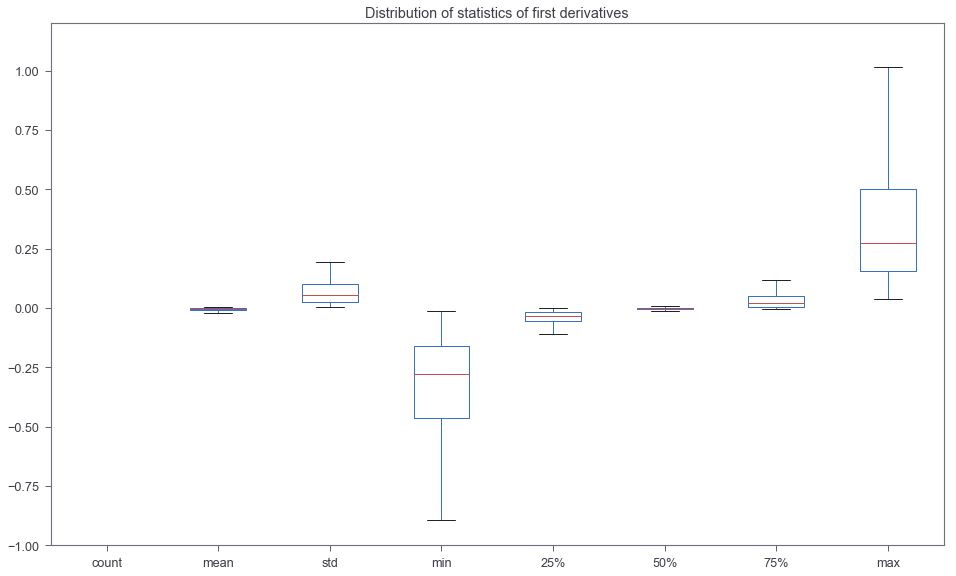

In [45]:
data.diff().describe().T.plot(kind='box')
plt.ylim(-1, 1.2)
plt.title("Distribution of statistics of first derivatives")
plt.show()

The graph indicates that most series tend to have similar trends but some exhibit sharp changes.

In [46]:
pca_derivs = PCA(n_components=2)
pca_derivs.fit(data.diff().dropna().describe().T)
pca_derivs.explained_variance_ratio_

array([0.92858565, 0.06964759])

In [47]:
derivatives_data = pca_derivs.transform(data.diff().dropna().describe().T)

In [48]:
derivatives = pd.DataFrame(derivatives_data, columns="PC_der_1 PC_der_2".split())

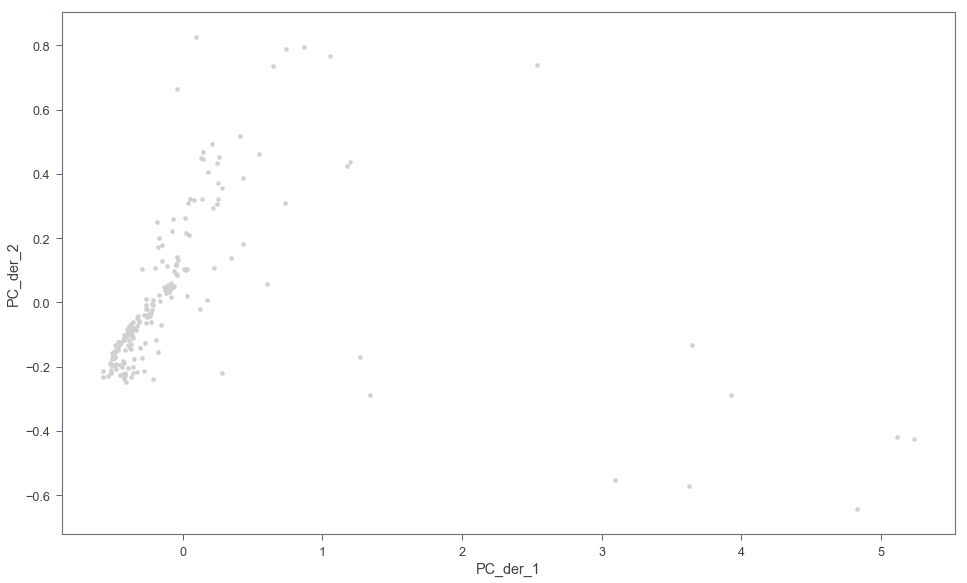

In [49]:
derivatives.plot(kind='scatter', x="PC_der_1", y="PC_der_2")
plt.show()

In [50]:
derivatives_data.shape

(200, 2)

In [51]:
data.diff().dropna().describe()

,n1,n4,n5,n6,n7,n10,n11,n12,n13,n14,...,n250,n251,n252,n253,n254,n255,n256,n257,n260,n261
count,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,...,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000,555.000000
mean,-0.013584,-0.004816,0.000225,0.000586,0.000820,-0.016382,0.000220,-0.004371,-0.003369,-0.004714,...,-0.000960,-0.001038,0.000108,-0.000578,0.001288,0.001250,-0.000843,0.001072,0.000402,-0.001182
std,0.113048,0.016179,0.084983,0.105552,0.089305,0.034429,0.185097,0.010982,0.031547,0.034530,...,0.068991,0.040749,0.042883,0.042545,0.019526,0.018953,0.105708,0.020009,0.108303,0.107250
min,-0.442000,-0.070000,-0.394000,-0.447000,-0.416000,-0.186000,-1.377000,-0.071000,-0.141000,-0.152000,...,-0.313000,-0.169000,-0.172000,-0.176000,-0.278000,-0.224000,-0.460000,-0.216000,-0.449000,-0.450000
25%,-0.067500,-0.013000,-0.045500,-0.055500,-0.045000,-0.030500,-0.013000,-0.010000,-0.016000,-0.021000,...,-0.036000,-0.020500,-0.021000,-0.023500,-0.004000,-0.005000,-0.057000,-0.004000,-0.056000,-0.056500
50%,-0.010000,-0.005000,0.005000,0.005000,0.002000,-0.015000,-0.001000,-0.003000,-0.001000,-0.003000,...,0.000000,0.000000,0.001000,0.002000,0.001000,0.000000,0.001000,0.000000,0.005000,0.003000
75%,0.050000,0.002000,0.048000,0.058500,0.051000,-0.001000,0.014000,0.000000,0.011000,0.011000,...,0.035000,0.020000,0.020000,0.022000,0.006000,0.007000,0.058500,0.007000,0.066500,0.060500
max,0.475000,0.108000,0.378000,0.480000,0.385000,0.205000,1.376000,0.059000,0.189000,0.217000,...,0.325000,0.223000,0.210000,0.236000,0.158000,0.140000,0.449000,0.113000,0.447000,0.503000
